# Credit Card Default Classification Project



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

%matplotlib inline

#pd.options.display.max_columns = None

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Import Data

In [2]:
df = pd.read_csv('DATA/training_data.csv',  index_col = 0)
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,...,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,...,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


# Data Cleaning & EDA

It seems like there's a row that's supposed to be the header.

In [3]:
df = df.rename(columns = df.loc['ID'])
df = df.drop([df.index[0], 'ID'])
df = df.rename(columns = {'default payment next month': 'Y'})

In [4]:
#df.info()

They are still all objects. Let's take a look at each of their unique values, if they don't have to be objects, I'll convert them.

In [5]:
#df.describe()

In [6]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y'],
      dtype='object')

In [7]:
categorical = ['SEX', 'EDUCATION', 'MARRIAGE']
for c in df.columns:
    if c not in categorical: 
        df[c] = pd.to_numeric(df[c])

#for c in df.columns[0:5]:
#    print (f"{c}: {df[c].unique()}")

### Default (Y)

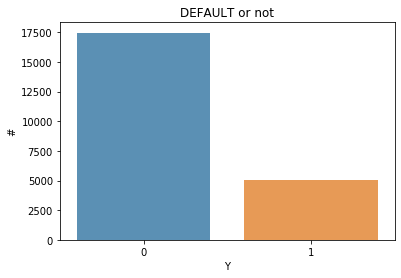

In [8]:
sns.countplot(df['Y'], alpha =.80)
plt.title('DEFAULT or not')
plt.ylabel('#')
plt.show()

### Credit Limit

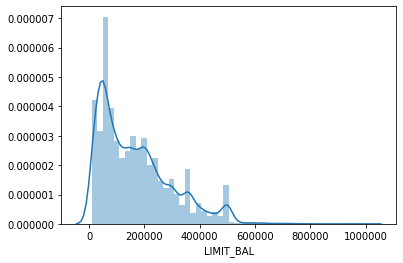

In [9]:
sns.distplot(df.LIMIT_BAL)

Some people seems to have very high credit limit, but nothing look abnormal.

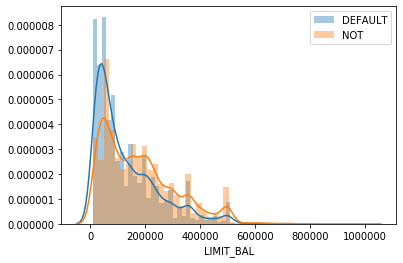

In [13]:
sns.distplot(df[df.Y == 1]['LIMIT_BAL'], hist = True, label='DEFAULT')
sns.distplot(df[df.Y == 0]['LIMIT_BAL'], hist = True, label='NOT')

plt.legend()
plt.show()

It seems like lower rate has a lot to do with defaulting.I'll add a column to indicate that.

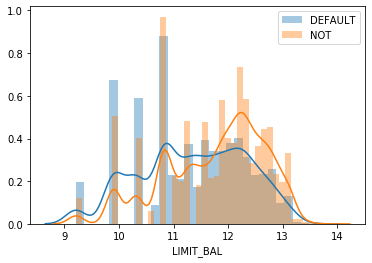

In [14]:
# try normalizing
sns.distplot(np.log(df[df.Y == 1]['LIMIT_BAL']),label='DEFAULT')
sns.distplot(np.log(df[df.Y == 0]['LIMIT_BAL']), label='NOT')

plt.legend()
plt.show()

In [40]:
df.groupby('Y').LIMIT_BAL.describe()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,17471.0,177919.523782,131708.375639,10000.0,60000.0,150000.0,250000.0,1000000.0
1,5027.0,129283.405610,115575.598882,10000.0,50000.0,90000.0,190000.0,720000.0


### SEX

In [15]:
df.SEX.value_counts()

2    13571
1     8927
Name: SEX, dtype: int64

Slight imbalance. 

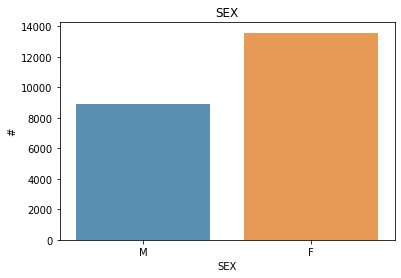

In [16]:
sns.countplot(df['SEX'], alpha =.80)
plt.title('SEX')
plt.xticks([0, 1], ['M', 'F'])
plt.ylabel('#')
plt.show()

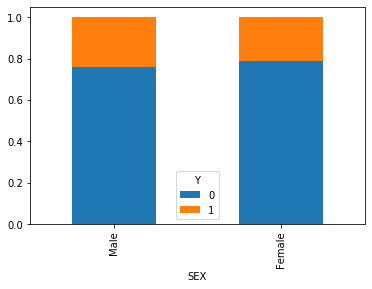

In [17]:
tmp = df.groupby(['SEX']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

It doesn't seem too much difference.

### Education

In [18]:
df.EDUCATION.value_counts()

2    10516
1     7918
3     3713
5      208
4       90
6       42
0       11
Name: EDUCATION, dtype: int64

There are unknown values above 4. We can roughly assume that higher education is linked to higher credit limit. Let's see if this matches up with the number system. 

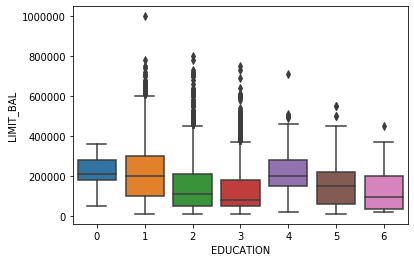

In [19]:
sns.boxplot(df.EDUCATION, df.LIMIT_BAL)

Okay, we cannot treat this as an ordinal group. We will treat as categorical.

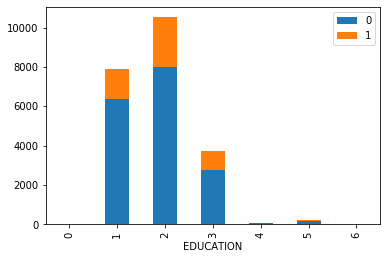

In [20]:
tmp = df.groupby(['EDUCATION']).Y.value_counts().unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

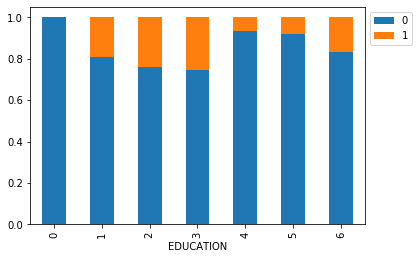

In [21]:
tmp = df.groupby(['EDUCATION']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

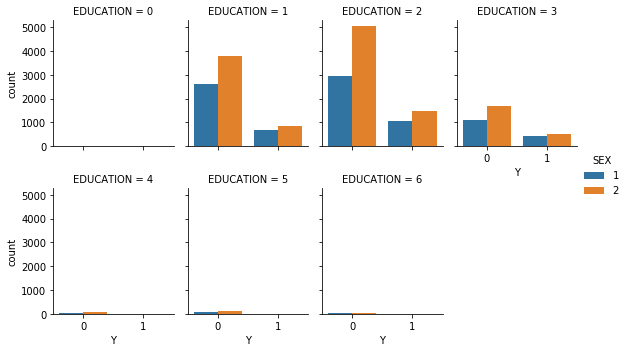

In [30]:
sns.catplot('Y', hue = 'SEX', col = 'EDUCATION', col_wrap = 4, data = df, kind = 'count', height = 2.5, aspect = 0.8)

### MARRIAGE

In [31]:
df.MARRIAGE.value_counts()

2    12025
1    10195
3      234
0       44
Name: MARRIAGE, dtype: int64

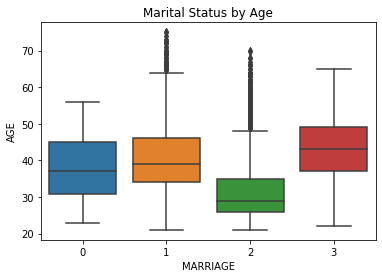

In [32]:
sns.boxplot(x = 'MARRIAGE', y = 'AGE', data = df).set_title('Marital Status by Age')
plt.show()

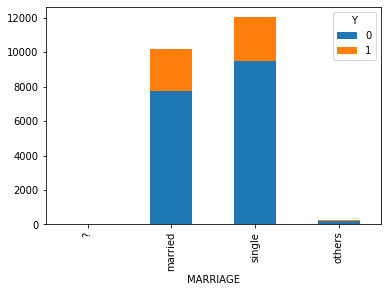

In [33]:
tmp = df.groupby(['MARRIAGE']).Y.value_counts().unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1, 2, 3], ['?', 'married', 'single', 'others'])
plt.show()

I'm guessing 0 values are ones we don't have the information for but I'm going to leave as it for now.

In [ ]:
#df.MARRIAGE = df.MARRIAGE.replace('3', '0')

### Age

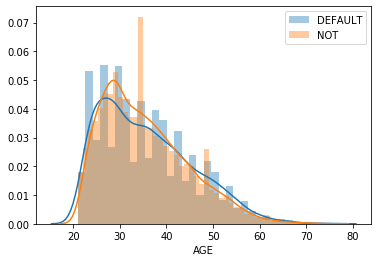

In [34]:
sns.distplot(df[df.Y == 1]['AGE'], label='DEFAULT')
sns.distplot(df[df.Y == 0]['AGE'], label='NOT')

plt.legend()
plt.show()

In [38]:
df.groupby('Y').AGE.describe()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,17471.0,35.375651,9.068939,21.0,28.0,34.0,41.0,75.0
1,5027.0,35.699025,9.799031,21.0,28.0,34.0,42.0,75.0


# Baseline Model
I'll create a basline logistic regression model using demographics only. 

In [41]:
def fit_logreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    logreg = LogisticRegression(class_weight = 'balanced', max_iter = 10000)
    logreg.fit(X_train, y_train)    
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)
    f1_train = round(f1_score(y_train, y_pred_train), 3)
    f1_test = round(f1_score(y_test, y_pred_test), 3)
    print(f"F1_train: {f1_train}")
    print(f"F1_test: {f1_test}")
    print(f"Test Accuracy: {round(accuracy_score(y_test, y_pred_test), 3)}")
    print(f"Test AUC: {round(roc_auc_score(y_test, y_pred_test), 3)}")

    return logreg, f1_train, f1_test

In [42]:
y = df['Y']
X = pd.get_dummies(df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']])

In [43]:
def corr_high(df):
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df['v1'] != corr_df['v2'])].sort_values(
        by = 'c', ascending = False)

corr_high(X)[1]

,v1,v2,c
33,SEX_1,SEX_2,1.000000
47,SEX_2,SEX_1,1.000000
193,MARRIAGE_1,MARRIAGE_2,0.975428
207,MARRIAGE_2,MARRIAGE_1,0.975428


In [44]:
X = X.drop(['SEX_2', 'MARRIAGE_1'], axis = 1)

In [45]:
lr = fit_logreg(X, y)

# Keeping a log of all models fitted

models= {'only_demographics_logreg': (lr[1], lr[2])}

F1_train: 0.0
F1_test: 0.0
Test Accuracy: 0.774
Test AUC: 0.5


### History of past payment
PAY0 ~ 6 are past payment status backwards (from Sept ~ April).  
Repayment status measurement scale is...  
-1: paid ontime  
1: delayed for one month  
2: delayed for 2 months  ...  
8: delayed for 8 months  
9: delayed for nine + months  

I want to first see if there are no values I don't understand.

In [47]:
pay_hist_names =[c for c in df if c.startswith('PAY')][0:6]

In [48]:
[df[x].unique() for x in pay_hist_names]

[array([-1, -2,  0,  2,  1,  3,  8,  4,  6,  5,  7], dtype=int64),
 array([-1, -2,  0,  2,  3,  4,  7,  5,  1,  8,  6], dtype=int64),
 array([-1, -2,  0,  2,  3,  4,  6,  5,  7,  8,  1], dtype=int64),
 array([-1, -2,  0,  2,  4,  5,  3,  7,  6,  8,  1], dtype=int64),
 array([-1, -2,  0,  2,  4,  3,  7,  5,  6,  8], dtype=int64),
 array([-1, -2,  0,  2,  4,  3,  7,  6,  8,  5], dtype=int64)]

Okay, there are 0 and -2, which are not the values we are supposed to have. I'll try to sample someone and see if we can figure it out.

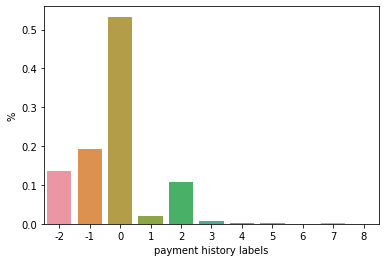

In [49]:
Y = pd.melt(df[pay_hist_names], value_vars = pay_hist_names).value.value_counts(normalize = True)
X = Y.index

sns.barplot(X, Y)
plt.xlabel('payment history labels')
plt.ylabel('%')
plt.show()

I want to assume that 0 is on time payment. But I'll feed in as categorical for now.  
On the other hand, these measures may highly correlating with others, since they can be accumulating balance.  
So we need a better measure for these that are not time sensative. We will add some measures later and remove these.  

In [ ]:
#corr_high(df)[1]

### Amount of Billing Statement & Payment
BILL_AMT1 ~ 6 are also backward statement from September ~ April.  
PAY_AMT1~6 are previous payment from Sept ~ April.  

In [53]:
bill_amt_names = [c for c in df if c.startswith('BILL_AMT')]
pay_amt_names = [c for c in df if c.startswith('PAY_AMT')]

In [54]:
# making a dataframe so I can plot performance each month
tmp2 = pd.melt(df[bill_amt_names].reset_index(), id_vars = 'index', value_vars=bill_amt_names, value_name='bill_amount')
tmp2 = tmp2.replace(tmp2.variable.unique(), [1, 2, 3, 4, 5, 6])

tmp3 = pd.melt(df[pay_amt_names].reset_index(), id_vars = 'index', value_vars=pay_amt_names, value_name='pay_amount')
tmp3 = tmp3.replace(tmp3.variable.unique(), [1, 2, 3, 4, 5, 6])

tmp = tmp2.merge(tmp3)

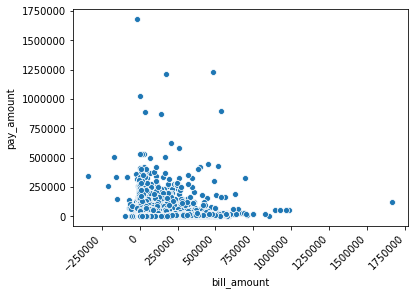

In [55]:
sns.scatterplot(x = 'bill_amount', y = 'pay_amount', data = tmp)
plt.xticks(rotation=45, ha='right')
plt.show()

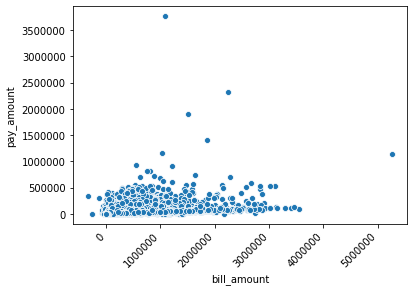

In [57]:
tmp_b = tmp.groupby('index').sum()
sns.scatterplot(x = 'bill_amount', y = 'pay_amount', data = tmp_b)
plt.xticks(rotation=45, ha='right')
plt.show()

In [58]:
#tmp[tmp['index'] == tmp_b[tmp_b['pay_amount'] > 3500000].index[0]]
#tmp[tmp['index'] == tmp_b[tmp_b['bill_amount'] > 5000000].index[0]]

Some outliers, but I have no evidence to delete them.

### Feature Engineering

#### Payment History
Instead of having each month record, I'll add the number of time for each category. 

In [59]:
payment_hist = pd.melt(df.reset_index(), id_vars = 'index', value_vars=pay_hist_names).groupby(['index', 'value']).count().unstack()
payment_hist = payment_hist.fillna(0)
payment_hist.columns = ['pay_hist_n2', 'pay_hist_n1', 'pay_hist_0', 'pay_hist_1', 'pay_hist_2', 'pay_hist_3', 'pay_hist_4', 
                       'pay_hist_5', 'pay_hist_6', 'pay_hist_7', 'pay_hist_8']

In [65]:
df = df.join(payment_hist)
cols_to_drop = pay_hist_names[2:]

#### Add the Balance Info (at the end of the month)
I'll remove this later.

In [67]:
# bill first pay first?
print(sum(df['BILL_AMT2'] == df['PAY_AMT1']))
print(sum(df['BILL_AMT1'] == df['PAY_AMT1']))

4887
1602


In [71]:
for i in range(6, 1, -1):
    df[f"BAL_{i}"] = df[f"BILL_AMT{i}"] - df[f"PAY_AMT{i-1}"]

In [76]:
# average balance
df['AVG_BAL'] = df[[c for c in df if c.startswith('BAL_')]].mean(axis = 1)

In [83]:
cols_to_drop = cols_to_drop + bill_amt_names + ['PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1'] + [c for c in df if c.startswith('BAL_')]

#### Add the cumulative change of balance

In [84]:
for i in range(6, 2, -1):
    df[f"BAL_change_{i}"] = df[f"BAL_{i}"] - df[f"BAL_{i-1}"]

In [85]:
df["cum_bal_change"] = df[[c for c in df if c.startswith('BAL_change')]].sum(axis = 1)

In [86]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith("BAL_change")]

#### final balance and payment

In [89]:
df['final_balance'] = df['BILL_AMT1']

In [90]:
df['final_payment'] = df['PAY_AMT1']

#### Add N_Default
How often they paid less than minimum.

In [91]:
for i in range(1, 7):
    df[f"DEF_{i}"] = np.where(((df[f"BILL_AMT{i}"] >= 35) & (df[f"PAY_AMT{i}"] < 35)) | 
                              ((df[f"BILL_AMT{i}"] < 35) & (df[f"PAY_AMT{i}"] < df[f"BILL_AMT{i}"])), 1, 0)

In [98]:
df['N_underpayment'] = df[[c for c in df if c.startswith('DEF')]].sum(axis = 1)

In [99]:
df['avg_underpayment'] = df[[c for c in df if c.startswith('DEF')]].mean(axis = 1)

In [101]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('DEF')][2:]

#### Add Over Credit Limit
number of times they spent over the credit limit.

In [102]:
for i in range(1, 7):
    df[f"over_lim_{i}"] = np.where(df[f"BILL_AMT{i}"] > df[f"LIMIT_BAL"], 1, 0)

In [103]:
df["n_over_lim"] = df[[c for c in df if c.startswith('over_lim')]].sum(axis = 1)

In [104]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('over_lim')]

#### Add Percent Use
Percentage of credit limit used

In [105]:
for i in range(1, 7):
    df[f"percent_use_{i}"] = df[f"BILL_AMT{i}"] / df[f"LIMIT_BAL"]
    
df['avg_percent_use'] = df[[c for c in df if c.startswith('percent_use')]].mean(axis = 1)

In [106]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('percent_use')]

#### Add Pattern Change
Add percent of payment to balance then subtract the most recent one from the old one

In [107]:
for i in range(1, 7):
    df[f"percent_paid_{i}"] = np.where(df[f"BILL_AMT{i}"] > 0, df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i}"], 1)
    
df['payment_patter_change'] = df['percent_paid_6'] - df['percent_paid_1']
df['bill_change'] = df['BILL_AMT6'] - df['BILL_AMT1']

In [108]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('percent_paid')]

#### Add Average Percent Paid

In [109]:
df['payment_average_p'] = df[[c for c in df if c.startswith('percent_paid')]].mean(axis = 1)

#### Max bill amount

In [111]:
df['max_bill'] = df[bill_amt_names].max(axis = 1)

#### Transform to a Log Limit
data was highly right skewed. it'll fit better if we normalize it a bit.

In [113]:
df['ln_limit_bal'] = np.log(df['LIMIT_BAL'])
df['low_limit_bal'] = np.where(df['ln_limit_bal'] < 10.5, 1, 0)

In [114]:
cols_to_drop = cols_to_drop + ['LIMIT_BAL']

### Categorical columns
Let's determine whether to use some of the ordinal columns as continuous or as categorical

In [119]:
df_clean = df.drop(cols_to_drop, axis = 1)

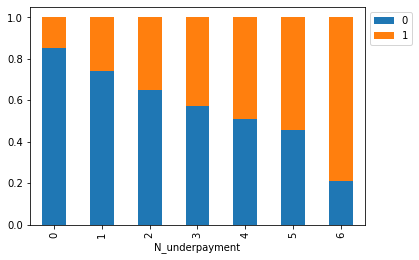

In [126]:
tmp = df_clean.groupby(['N_underpayment']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

In [131]:
categories = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2']

In [133]:
df_ohe = pd.get_dummies(df_clean, columns = categories)

### Standardization
I'll standardize the measures.

In [138]:
from sklearn.preprocessing import StandardScaler

y = df_ohe['Y'].values
X = df_ohe.drop(['Y'], axis = 1)

scaler = StandardScaler()
scaler.fit(X)
df_std = pd.DataFrame(scaler.transform(X), columns= X.columns)
df_std['Y'] = y

### Fit everything

In [140]:
y = df_std['Y']
X = df_std.drop(['Y'], axis = 1)
lr1 = fit_logreg(X, y)

models['after_feat_eng'] = (lr1[1], lr1[2])

F1_train: 0.531
F1_test: 0.539
Test Accuracy: 0.774
Test AUC: 0.704


Much better F1 and accuracy, but it's still useless.

### Add Polynomials
Find the most meaningful polynomials and add.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X = df_std.drop('Y', axis = 1)

polys = pd.DataFrame(columns = ['col', 'degree', 'f1'])
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 10000)
cv = KFold(n_splits = 5, shuffle = True, random_state = 2)
thresh = np.mean(cross_val_score(logreg, X, y, scoring = 'f1', cv = cv))

i = 0
for c in X.columns:
    i += 1
    print(i, '/', len(X.columns))
    for deg in [2, 3]: 
        X2 = X.copy()
        poly = PolynomialFeatures(deg, include_bias = False)
        X2[c] = poly.fit_transform(X2[[c]])
        score = np.mean(cross_val_score(logreg, X2, y, scoring = 'f1', cv = cv))
        if score > thresh: 
            print(c, deg, score)
            polys.loc[len(polys)] = [c, deg, f1]

### Add Interaction
Find the most meaningful interactions and add.

In [ ]:
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def add_interaction(X, y): 
    allpairs = list(combinations(X.columns, 2))

    interactions = pd.DataFrame(columns = ['pair', 'f1'])
    logreg = LogisticRegression(class_weight = 'balanced', max_iter = 5000)
    cv = KFold(n_splits = 3, shuffle = True, random_state = 2)
    thresh = np.mean(cross_val_score(logreg, X, y, scoring = 'f1', cv = cv))
    i = 0
    for pair in allpairs:
        i += 1
        X['interaction'] = X[pair[0]] * X[pair[1]]
        score = np.mean(cross_val_score(logreg, X, y, scoring = 'f1', cv = cv))
        if score > thresh: 
            interactions.loc[len(interactions)] = [pair, score]
    return interactions

#interactions = add_interaction(X, y)

#interactions.head()


In [ ]:
#interactions.to_pickle('interaction.pkl')

In [ ]:
interactions = pd.read_pickle('interaction.pkl')

In [ ]:
interactions.sort_values(by = ['f1'], ascending = False)[0:10]

In [ ]:
tmp = interactions.sort_values(by = ['f1'], ascending = False)[0:10][['pair']]
for i in range(len(tmp)):
    pair = tmp.iloc[0][0]
    df[f'{pair[0]}X{pair[1]}'] = df[pair[0]] * df[pair[1]]

In [ ]:
y = df['Y']
X = df.drop(['Y'], axis = 1)
lr1 = fit_logreg(X, y)

models['raw_after_interactions'] = (lr1[1], lr1[2])

In [ ]:
y = df['Y']
X = df.drop(['Y'] + cols_to_drop, axis = 1)
lr2 = fit_logreg(X, y)

models['interactions_removing_old_feats'] = (lr2[1], lr2[2])

### Train Test Split
For the rest of model evaluation, I'll split the dataset.

In [ ]:
#df.to_pickle('final_df.pkl')

In [ ]:
Y = df['Y']
X = df.drop(['Y'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Class Imbalance Problem
First, we will balance out our train samples with the best method. (I don't have to use this for decision trees)

In [ ]:
# Balanced weight method
lr_weight = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter = 10000)
lr_weight.fit(X_train, y_train)
lr_weight_test = lr_weight.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, lr_weight_test))
print('Test F1 score: ', f1_score(y_test, lr_weight_test))

In [ ]:
# SMOTE Oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

smote_lr = LogisticRegression(solver='liblinear', max_iter = 10000)
smote_lr.fit(X_train_resampled, y_train_resampled)
smote_lr_test = smote_lr.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, smote_lr_test))
print('Test F1 score: ', f1_score(y_test, smote_lr_test))

In [ ]:
# Tomek Links Undersampling
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
X_train_resampled, y_train_resampled = tl.fit_sample(X_train, y_train)

tl_lr = LogisticRegression(solver='liblinear', max_iter = 10000)
tl_lr.fit(X_train_resampled, y_train_resampled)
tl_lr_test = tl_lr.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, tl_lr_test))
print('Test F1 score: ', f1_score(y_test, tl_lr_test))

It seems like SMOTE sometimes does well but balanced weight control works the best.

## Model Evaluation
### Logistic Regression
I'm going to now compare model performance. I'll first do multiple logistic regressions and test couple different things.
1. Choose the best way to control for multicollinearity (VIF vs manual controls vs. variance threshold)
2. Try regularizations (L1, L2) + find the best C 

### Multicollinearity choice for Logistic Regression
#### Manual control

In [ ]:
# check correlation
#corr_high(X_train)[1]

In [ ]:
# drop manually
X_train_manual = X_train.drop(cols_to_drop + ['SEX_2', 'PAY_AMT1', 'MARRIAGE_2', 'pay_hist_2'], axis = 1)
X_test_manual = X_test.drop(cols_to_drop + ['SEX_2', 'PAY_AMT1', 'MARRIAGE_2', 'pay_hist_2'], axis = 1)


In [ ]:
def Logreg_testing(X_train, X_test, colname):
    lr = LogisticRegression(solver='liblinear', class_weight = 'balanced', max_iter = 10000)
    lr.fit(X_train, y_train)

    lr_train = lr.predict(X_train)
    lr_test = lr.predict(X_test)
    
    f1_train = round(f1_score(y_train, lr_train), 3)
    f1_test = round(f1_score(y_test, lr_test), 3)
    print('Train F1 score: ', f1_train)
    print('Test F1 score: ', f1_test)
    models[colname] = (f1_train, f1_test)
    return models

Logreg_testing(X_train_manual, X_test_manual, 'manual_corr')

#### VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X_train)

In [ ]:
X_train_VIF = X_train.drop(list(Vif.Features[Vif.VIF > 10].values), axis = 1)
X_test_VIF = X_test[X_train_VIF.columns]

In [ ]:
Logreg_testing(X_train_VIF, X_test_VIF, 'VIF')

#### Lasso/Ridge Regression

In [ ]:
# first data needs to be scaled
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns)

# Use standardized data with less features
scaled_X_train_controlled = scaled_X_train[X_train_manual.columns]
scaled_X_test_controlled = scaled_X_test[X_train_manual.columns]

In [ ]:
# grid search hyperparams
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}
lr_l1 = LogisticRegression(random_state = 2, solver = 'liblinear', penalty = 'l1')
lr_g = GridSearchCV(lr_l1, params, cv = 5, scoring = 'f1', verbose = 1, n_jobs = -1)
lr_g.fit(scaled_X_train, y_train)

print(lr_g.best_params_, ': ', lr_g.best_score_)

y_pred = lr_g.best_estimator_.predict(scaled_X_test)    
y_pred_train = lr_g.best_estimator_.predict(scaled_X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

In [ ]:
models['lasso'] = (f1_train, f1_test)


In [ ]:
# after multicollinearity solved

In [ ]:
# grid search hyperparams
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}
lr_l1 = LogisticRegression(random_state = 2, solver = 'liblinear', penalty = 'l1')
lr_g = GridSearchCV(lr_l1, params, cv = 5, scoring = 'f1', verbose = 1, n_jobs = -1)
lr_g.fit(scaled_X_train_controlled, y_train)

print(lr_g.best_params_, ': ', lr_g.best_score_)

y_pred = lr_g.best_estimator_.predict(scaled_X_test_controlled)    
y_pred_train = lr_g.best_estimator_.predict(scaled_X_train_controlled)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

In [ ]:
models['lasso_control'] = (f1_train, f1_test)


### AIC/BIC

### KNN 
Fit KNN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': range(1, 25, 2),
}

knc = KNeighborsClassifier()
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'f1', verbose = 1, n_jobs = -1)
knc_g.fit(scaled_X_train, y_train)

print(knc_g.best_params_, ': ', knc_g.best_score_)

y_pred = knc_g.best_estimator_.predict(scaled_X_test)    
y_pred_train = knc_g.best_estimator_.predict(scaled_X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)
models['knn'] = (f1_train, f1_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': range(1, 25, 2),
}

knc = KNeighborsClassifier()
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'f1', verbose = 1, n_jobs = -1)
knc_g.fit(scaled_X_train_controlled, y_train)

print(knc_g.best_params_, ': ', knc_g.best_score_)

y_pred = knc_g.best_estimator_.predict(scaled_X_test_controlled)    
y_pred_train = knc_g.best_estimator_.predict(scaled_X_train_controlled)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)
models['knn_control'] = (f1_train, f1_test)

None of these methods are improving the model any more than the logistic regression...

### Decision Trees
Fit different decision trees

In [ ]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train_resampled, y_train_resampled)
y_pred_train = clf.predict(X_train_resampled)
y_pred = clf.predict(X_test)

f1_train = round(f1_score(y_train_resampled, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)
models['simple_tree_ID3'] = (f1_train, f1_test)

In [ ]:
# find the best hyperparameters for simple decision tree
parameters={'max_depth': range(3,8,1),  
            'min_samples_split':range(1,10,1),
            'min_samples_leaf':range(1,10,1),
            'criterion': ['gini', 'entropy'] 
           }

dtc = DecisionTreeClassifier(random_state=1)

tree_g = GridSearchCV(dtc, parameters, cv=5, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train_resampled,y_train_resampled)

print(tree_g.best_params_, ': ', tree_g.best_score_)

y_pred = tree_g.best_estimator_.predict(X_test)    
y_pred_train = tree_g.best_estimator_.predict(X_train_resampled)    

f1_train = round(f1_score(y_train_resampled, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)
models['decision_tree_gridsearch'] = (f1_train, f1_test)

In [ ]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dtc = DecisionTreeClassifier(random_state=1, criterion = 'ginig', max_depth = 7, min_samples_leaf = 7, min_samples_split = 2)
dtc.fit(X_train_resampled,y_train_resampled)

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = scaled_X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('simple_decision_tree.png')
Image(graph.create_png())

### Ensemble Methods
Test ensemble methods

In [ ]:
# Random forest



In [ ]:
import xgboost as xgb

# find the best hyperparameters for simple decision tree
parameters={'eta': [0.1, 0.3, 0.5, 0.7],
            'max_depth':range(3, 8, 1)
           }

xgbc = xgb.XGBClassifier()
xgbc_g = GridSearchCV(xgbc, parameters, cv=5, scoring='f1', verbose = 1,  n_jobs = -1)

xgbc_g.fit(X_train_resampled, y_train_resampled)

print(xgbc_g.best_params_, ': ', xgbc_g.best_score_)

y_pred = xgbc_g.best_estimator_.predict(X_test)    
y_pred_train = xgbc_g.best_estimator_.predict(X_train_resampled)    

f1_train = round(f1_score(y_train_resampled, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)
models['XGBoost_best_params'] = (f1_train, f1_test)